In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


In [3]:
months = ['Jan','Apr']

In [4]:
G = {}
for month in months:
    G[month] = xr.open_dataarray(f'Outputs/G_SEA_{month}_BC_total.nc4')


In [5]:
G_ds = xr.concat([G[month] for month in months], pd.Index([month for month in months], name = 'start_date'))

## Import area/height for weighting

In [6]:
area_ds = xr.open_dataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4')

In [7]:
area_ds = utils.fix_area_ij_latlon(area_ds)


In [8]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [9]:
height = height.reindex(index=height.index[::-1])

In [10]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [11]:
#ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
area_ds = xr.merge([area_ds, height_ds], join = 'inner')

# Global Average

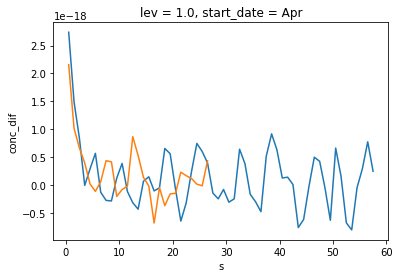

In [12]:
for month in months:
    G_ds.sel(start_date = month).isel(lev = 0).weighted(area_ds['area']).mean(dim = ['lat','lon']).plot()


# Regional Mean test

In [13]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

regions = regionmask.defined_regions.ar6.land


In [14]:
mask = regions.mask(G_ds, lon_name = 'lon', lat_name = 'lat')
#38 is SEA
contiguous_mask = ~np.isnan(mask)& (mask == 38)
G_SEA = G_ds.where(contiguous_mask)
#fig, ax = plt.subplots()
#G[month].isel(lev = 0, s = 0).plot()

In [15]:
G_SEA = G_SEA.isel(lev = 0).weighted(area_ds['area']).mean(dim = ['lat','lon'])


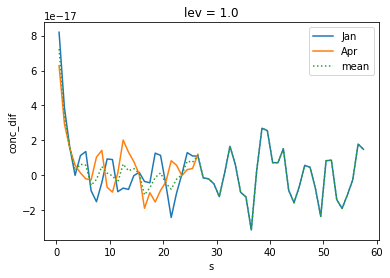

In [16]:
for month in months:   
    G_SEA.sel(start_date = month).plot(label = month)
G_SEA.mean(dim = 'start_date').plot(label = 'mean', linestyle = ':')
plt.legend()

## Spatially Resolved lev 0

In [17]:
G_avg = G_ds.mean(dim = 'start_date').isel(lev = 0)

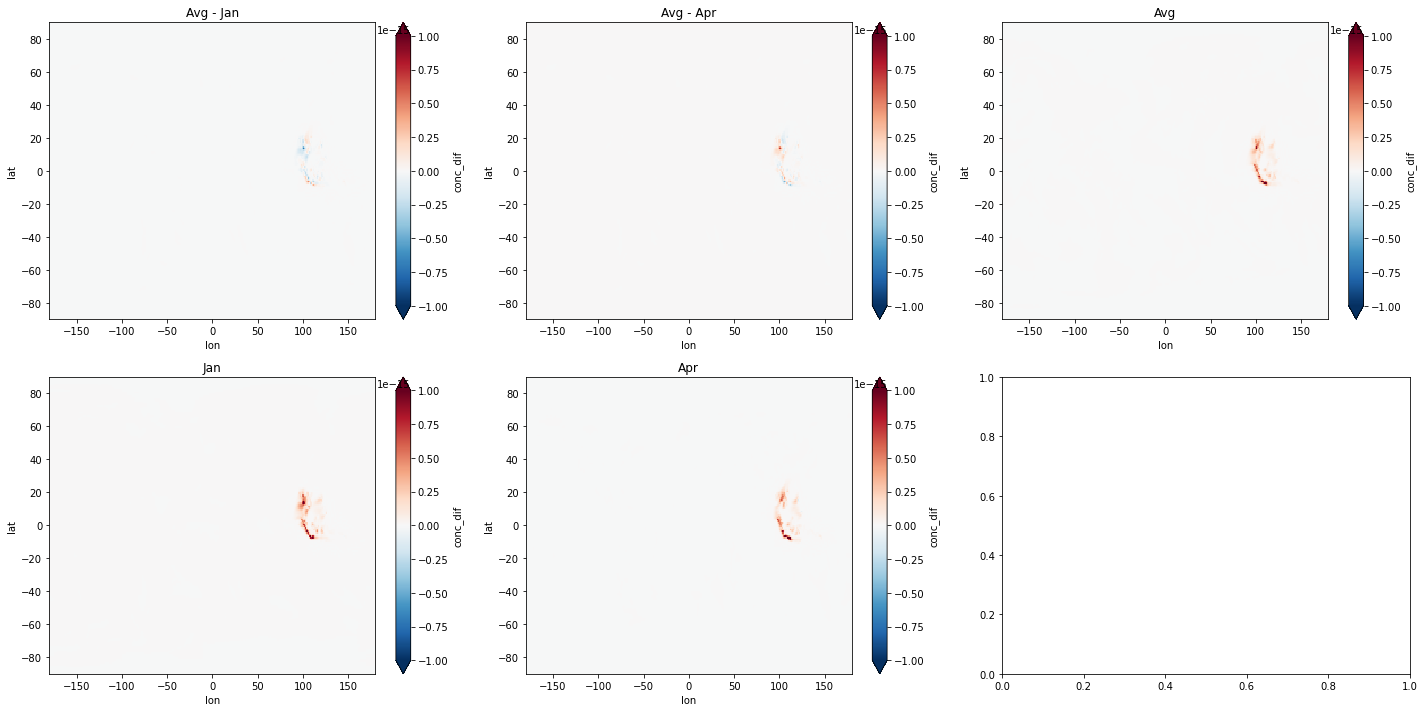

In [58]:
fig, axes = plt.subplots(2,3, figsize = [20,10])
cmap = 'RdBu_r'
vmin = -1e-15
vmax = 1e-15
extend = 'both'
(G_avg.isel(s = 0) - G_ds.sel(start_date = 'Jan').isel(s = 0, lev = 0)).plot(ax = axes[0,0], vmin = vmin, vmax = vmax, cmap = cmap, extend = extend)
axes[0,0].set_title('Avg - Jan')
(G_avg.isel(s = 0) - G_ds.sel(start_date = 'Apr').isel(s = 0, lev = 0)).plot(ax = axes[0,1], vmin = vmin, vmax = vmax, cmap = cmap, extend = extend)
axes[0,1].set_title('Avg - Apr')
G_avg.isel(s = 0).plot(ax = axes[0,2], vmin = vmin, vmax = vmax, cmap = cmap, extend = extend)
axes[0,2].set_title('Avg')
(G_ds.sel(start_date = 'Jan').isel(s = 0, lev = 0)).plot(ax = axes[1,0], vmin = vmin, vmax = vmax, cmap = cmap, extend = extend)
axes[1,0].set_title('Jan')
(G_ds.sel(start_date = 'Apr').isel(s = 0, lev = 0)).plot(ax = axes[1,1], vmin = vmin, vmax = vmax, cmap = cmap, extend = extend)
axes[1,1].set_title('Apr')
plt.tight_layout()